__Predicting Car Prices from Car Attributes using the scikit-learn [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html?highlight=kneighborsregressor#sklearn.neighbors.KNeighborsRegressor).__

We will use various attributes of individual cars and their known sale prices to produce a k-nearest neighbors model. The KN model will then attempt to predict sales prices of cars with similar attributes. 

The car sales prices are assumed to be continuous which is why the KNeighborsRegressor is used instead of the KNeighborsClassifier - the latter being more suitable for predicting category classifications. 

The full data set has a price range of \\$40,000 with a mean \\$13,200 +/- 8,000. The final model performs well, yielding an RMSE score of \\$2,384.3. However the _KNeighborsRegressor()_ can only use ~50\% of the available (non-numerical) attributes - and excludes very obvious attributes such as 'make'. For this reason _KNeighborsRegressor()_ is unlikely to be the most optimal scikit-learn model for this task. 

The data set used is the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile) from the Machine Learning Repository. The workflow is following a [DataQuest](https://app.dataquest.io/m/155/guided-project%3A-predicting-car-prices/1/introduction-to-the-data-set) _Guided project_.

# Initial inspection of the data set

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
%matplotlib inline

The supplied data is not supplied with column headings - the column names are those specified in the documentation.

In [2]:
# load data
cars = pd.read_csv('imports-85.data')
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 
        'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data', names=cols)
cars.head(1)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495


In [3]:
cars.dtypes

symboling              int64
normalized-losses     object
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                  object
stroke                object
compression-rate     float64
horsepower            object
peak-rpm              object
city-mpg               int64
highway-mpg            int64
price                 object
dtype: object

Select only the columns with [continuous values](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names) such that they can fit into the KNeighborsRegressor model. 

In [4]:
continuous_values_cols = [
    'normalized-losses', 'wheel-base', 'length', 'width', 'height', 
    'curb-weight', 'bore', 'stroke', 'compression-rate', 'horsepower', 
    'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

continuous_values_cols = [
    'normalized-losses', 'wheel-base', 'length', 'width', 'height', 
    'curb-weight', 'engine-size',   
                'bore', 'stroke', 'compression-rate', 'horsepower', 
    'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

numeric_cars = cars[continuous_values_cols]
numeric_cars = numeric_cars.replace('?', np.nan) # replace default missing
numeric_cars = numeric_cars.astype('float')
numeric_cars.head(2)

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,NaN,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,13495.0
1,NaN,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,16500.0


## Data cleaning

__Remove missing values__: Rows with missing prices are useless since this is what we will use to train the model. These rows will need to be dropped. 

In [5]:
missing_prices = numeric_cars['price'].isnull()
numeric_cars.dropna(subset=['price'],inplace=True)

print('Dropped {0} rows with missing prices'.format(missing_prices.sum()))

Dropped 4 rows with missing prices


In [6]:
numeric_cars.isnull().sum()/numeric_cars.shape[0]*100

normalized-losses    18.407960
wheel-base            0.000000
length                0.000000
width                 0.000000
height                0.000000
curb-weight           0.000000
engine-size           0.000000
bore                  1.990050
stroke                1.990050
compression-rate      0.000000
horsepower            0.995025
peak-rpm              0.995025
city-mpg              0.000000
highway-mpg           0.000000
price                 0.000000
dtype: float64

The number of missing values - at 18.4% or ~37 rows - within _normalized-losses_ is significant. 

In [7]:
correlations = numeric_cars.corr()[['price','normalized-losses']]
correlations.abs().sort_values('normalized-losses',ascending=False)

,price,normalized-losses
normalized-losses,0.203254,1.000000
height,0.135486,0.432335
horsepower,0.810533,0.295772
peak-rpm,0.101649,0.264597
city-mpg,0.686571,0.258502
highway-mpg,0.704692,0.210768
price,1.000000,0.203254
engine-size,0.872335,0.167365
compression-rate,0.071107,0.132654
curb-weight,0.834415,0.119893


For the values that do exist, the correlation of _normalized-losses_ is on the edge of being a reasonable predictor of the sale price.
However, other than _height_ , _normalized-losses_ is largely independent to all other fields too. 

For this reason we should include it (for now) within the model. All missing values will use the mean() of each column.

In [8]:
numeric_cars = numeric_cars.fillna(numeric_cars.mean())

Next, scale all columns to values between range from 0 to 1.

In [9]:
cars_scaled = numeric_cars.copy()
cars_scaled = (cars_scaled - cars_scaled.min()) / (cars_scaled.max() - cars_scaled.min())
cars_scaled['price'] = numeric_cars['price']
cars_scaled.head(3)

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.125,0.294393,0.346939,0.222222,0.289474,13495.0
1,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.125,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.125,0.495327,0.346939,0.166667,0.263158,16500.0


# A simple k-nearest neighbors model

Loop over each column (car attribute) in the DataFrame and assess the predictive power of each attribute when used to compute the car sale price.

1, Split the data randomly into two halves. 2, Train the model on the 1st half. 3, Test the model on the 2nd half. 4, Assess the predictive capabilities of each model using RMSE.

In [10]:
from random import sample
def knn_train_test(df, train_col, target_col, k_value=5):
    '''Split a DataFrame into Training and test data. Then 
    fit/test a KNeighborsRegressor() model one column at a time.
    '''
    # randomise the dataframe
    df = df.sample(frac=1,random_state=1).reset_index(drop=True)
    # split into training and test data
    train_df = df.iloc[0:int(df.shape[0]/2)].copy()
    test_df  = df.iloc[int(df.shape[0]/2):].copy()
    
    # Fit
    knn = KNeighborsRegressor(n_neighbors=k_value)
    knn.fit(train_df[[train_col]],train_df[target_col])
    # predict
    predictions = knn.predict(test_df[[train_col]])
    
    # return the RMSE
    return mean_squared_error(test_df[target_col],predictions)**.5 

In [11]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
#Function for univariate knn
def knn_train_test(df,feature_col,target_col,k=5):
    
    # Randomize order of rows in data frame.
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    #Do 50% hold out split for training and test sets
    half = round(len(rand_df)/2)
    training_set = df.iloc[0:half].copy()
    test_set = df.iloc[half:].copy()
    
    #Initialise knn model
    knn = KNeighborsRegressor(n_neighbors=k)
    
    #train the model
    knn.fit(training_set[[feature_col]],training_set[target_col])
    
    #test the model
    predictions = knn.predict(test_set[[feature_col]])
    
    #Evaluate the model
    rmse = rmse = np.sqrt(mean_squared_error(predictions, test_set[target_col]))
    
    return rmse

Now loop over each column in a dataframe and return the RMSE for each when predicting the sale price.

In [12]:
best_fit = {}
cars_scaled_cols = cars_scaled.columns[cars_scaled.columns != 'price']
for target_col in cars_scaled_cols:
    best_fit[target_col] = knn_train_test(cars_scaled,target_col,'price')

# Produce a 
best_fit = pd.Series(best_fit)
best_fit.sort_values(inplace=True)

It should be expected that a column/attribute that correlates well with the car sale price will yield a lower RMSE. 

,Correlations,RMSE
engine-size,0.872335,4190.433888
horsepower,0.810533,4267.730361
highway-mpg,0.704692,4628.793094
city-mpg,0.686571,4814.778015
curb-weight,0.834415,5166.828581
width,0.751265,7110.412630
compression-rate,0.071107,8096.301512
normalized-losses,0.203254,8131.436882
length,0.690628,8304.189346
stroke,0.082310,9334.714914


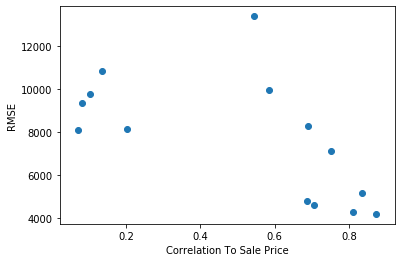

In [13]:
corr_vs_rmse = pd.DataFrame([correlations.abs()['price'][cars_scaled_cols],best_fit],
                             index=['Correlations','RMSE']).transpose()

plt.scatter(corr_vs_rmse['Correlations'],corr_vs_rmse['RMSE'])
plt.xlabel('Correlation To Sale Price')
plt.ylabel('RMSE')

corr_vs_rmse.sort_values(['RMSE'],inplace=True)
corr_vs_rmse

Next, compare the RMSE for individual attributes with incremental k_values.

Using all 13 attributes will create a busy graph. Instead pick the four _best_ and _worst_ attributes, using the above RMSE scores when k_value = 5.

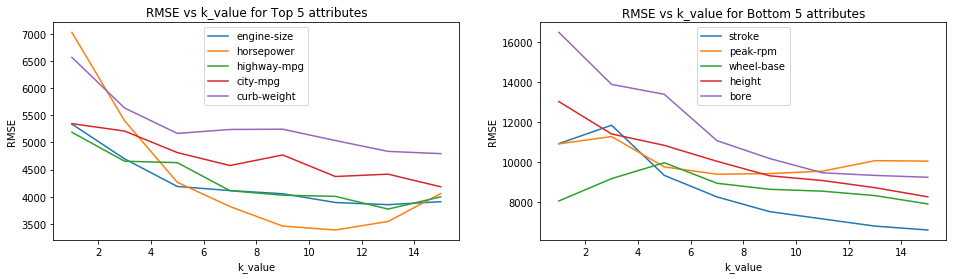

In [14]:
# corr_vs_rmse sorted in ascending RMSE
no_top_results = 5
best_cols  = corr_vs_rmse.iloc[0:no_top_results:,:].index # top 5
worst_cols = corr_vs_rmse.iloc[corr_vs_rmse.shape[0]-no_top_results:,:].index # bottom 5

fig, axs = plt.subplots(1,2, figsize=(16, 4))
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

plots = {
    'RMSE vs k_value for Top 5 attributes':best_cols,
    'RMSE vs k_value for Bottom 5 attributes':worst_cols }

k_values = (1, 3, 5, 7, 9, 11, 13, 15)

plot = 0
for title in plots:
    target_cols = plots[title]
    
    best_k = {}
    for col in target_cols:
        best_k[col] = {}
        for k_value in k_values:
            best_k[col][k_value] = knn_train_test(cars_scaled,col,'price',k_value)

    best_k_df = pd.DataFrame(best_k)
    for col in target_cols:
        axs[plot].plot(k_values, best_k_df[col], label=col)
    
    axs[plot].legend(loc='upper center')
    axs[plot].set_title(title)
    axs[plot].set_xlabel('k_value')
    axs[plot].set_ylabel('RMSE')
    plot += 1

The RMSE scores for the bottom 5 attributes do improve initially as the k_value increases, flattening out as k_value moves higher.

Whereras the RMSE scores for the top 5 attributes seem to have a sweet spot; such that the RMSE score improves initially as the k_value increases and then worsens as the k_value increases further. 

This is not too suprising. 

The top 5 attributes are by definition well correlated with the sale price. Increasing the k_value initially provides more information which improves the RMSE score. However because they are well correlated the additional _nearest neighbours_ will soon become unreliable indicators, blending the fit and so decreasing the predictive capabilities. 

Conversely, the bottom 5 attributes are by definition poorly correlated with the sale price. Therefore increasing the k_value should be expected to improves the RMSE score but the trade-off between information and noise will occur later. It should be expected that the RMSE will decrease again as the k_value increases further. However a bad fit can only be improved so much; it should be noted that the _best_ RMSE scores for all bottom 5 attributes are still worse that the _worst_ RMSE scores for all top 5 attributes. 

# Improving the k-nearest neighbors model

Instead of using just a single attribute for training and testing, reconfigure knn_train_test() to fit multiple specified attributes. For now the models will all use the default k_value = 5.

In [15]:
def knn_train_test(df, train_cols, target_col='price', k_value=5):
    '''Split a DataFrame into Training and test data. Then fit/test 
    a KNeighborsRegressor() model against multiple target attributes (train_cols).
    '''    
    # split the data set into two halves randomly
    df = df.sample(frac=1,random_state=1).reset_index(drop=True)    
    train_df = df.iloc[0:int(df.shape[0]/2)].copy()
    test_df  = df.iloc[int(df.shape[0]/2):].copy()
    
    # fit and predict
    knn = KNeighborsRegressor(n_neighbors=k_value)
    knn.fit(train_df[train_cols],train_df[target_col])
    predictions = knn.predict(test_df[train_cols])
    
    return mean_squared_error(test_df[target_col],predictions)**.5 

In [16]:
def fit_and_plot(knn_func,knn_kwargs={},k_values=np.arange(1,25,1), no_best_fits=[1, 2, 3, 4, 5]):
    '''Fit numerous kNN Model with varying values of k and a varying choice of "best fit attributes.
    Compute the RMSE for each model and plot the results. 
    
    knn_func is the function used to perform the fit and measure the RMSE.
    "'''
    
    all_k_fits = {}    
    for no_best_fit_cols in no_best_fits:        
        all_k_fits[no_best_fit_cols] = {}
        # choose the 'top' / best fitting attributes
        train_cols = best_fit[:no_best_fit_cols].index.tolist()
        # calculate the RMSE of the selected attributes against varying values of k
        for k_value in k_values:
            knn_kwargs['k_value'] = k_value
            rmse = knn_func( cars_scaled, train_cols, **knn_kwargs )
            all_k_fits[no_best_fit_cols][k_value] = rmse

    # plot k_value vs RMSE for each attribution selection
    for no_cols,v in all_k_fits.items():
        k_values = list(v.keys())
        rmses = list(v.values())

        plt.plot(k_values,rmses)        
        plt.title('Optimsed attribute selection: k_values vs RMSE')
        plt.xlabel('k value')
        plt.ylabel('RMSE')    

    plt.legend(all_k_fits.keys())

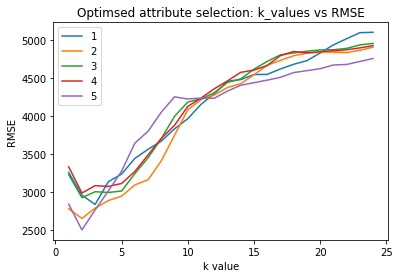

In [17]:
fit_and_plot( knn_train_test ) # perfom the varying attribution selection on knn_train_test()

There is some improvement in the predictive power of the kNN model when the number of car attributes used in tandem is increased. However the gains are not significant; the predictive power of 5 attributes (the best performing model) is only marginly better than when using two. 

Furthermore, all models perform best with low values for _k_. This is suspicious and may indicate that the data set has been overfit. Next, a __KFold__ model is used to split the data set into varying test/train splits. 

# KFold k-nearest neighbors model

In [18]:
def knn_KFold(df, train_cols, target_col='price', k_value=5, n_splits = 10):
    '''Using KFold, split a DataFrame multiple times (n_splits) into different training and test data 
    sets. Then fit/test a KNeighborsRegressor() model and score the average value of the RMSE. 
    '''  
    
    # initialise the splits
    kf = KFold(n_splits=n_splits, random_state=1, shuffle=True)    
    X = df[train_cols]
    y = df[target_col]

    rmse = 0
    for train_index, test_index in kf.split(cars_scaled):  
        # Split into test/train 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit and predict
        knn = KNeighborsRegressor(n_neighbors=k_value)
        knn.fit(X_train,y_train)
        predictions = knn.predict(X_test)

        rmse += mean_squared_error(y_test,predictions)**.5 

    return rmse / n_splits # average RMSE

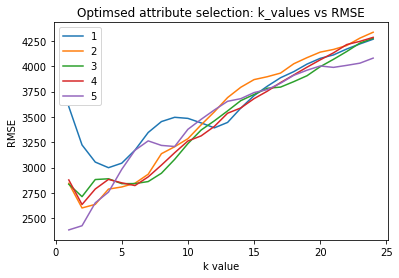

In [19]:
fit_and_plot( knn_KFold, knn_kwargs={'n_splits':10} ) # fit and plot using the new knn_KFold()

# Summary

In [20]:
cars_scaled.describe()['price'][['mean','std','min','max']] 

mean    13207.129353
std      7947.066342
min      5118.000000
max     45400.000000
Name: price, dtype: float64

Using the KFold (n_splits=10) model has smoothed out the RMSE scores and it is now clear that choosing the top 5 attributes yields the model with the best predictive power. 

The full data set has a price range of \\$40,000 with a mean \\$13,200 +/- 8,000. Therefore with an RMSE score of \\$2,384.3, the final model is performing well. 

However the optimal k value is still suspiciously very low (indeed it is 1). The correlation between the Top 5 columns offers a plausible explanation for this: 

In [21]:
train_cols = best_fit[:5].index.tolist()
cars_scaled[train_cols].corr()

,engine-size,horsepower,highway-mpg,city-mpg,curb-weight
engine-size,1.000000,0.822649,-0.679571,-0.650546,0.849072
horsepower,0.822649,1.000000,-0.804587,-0.822138,0.757994
highway-mpg,-0.679571,-0.804587,1.000000,0.972044,-0.794889
city-mpg,-0.650546,-0.822138,0.972044,1.000000,-0.749543
curb-weight,0.849072,0.757994,-0.794889,-0.749543,1.000000


All of the Top 5 attributes correlate closely. This is unsurprising given the attributes. _highway-mpg_ and _city-mpg_ both measures of fuel efficiency are almost perfectly correlated as would be expected. The Top 2 attributes _engine-size_ and _horsepower_ also correlate very closely; larger engines likely produce more power. _curb-weight_ is less obvious, but larger engines will weigh more and all things equal a heavier car will use more fuel. 

So plausibly these attributes are similar enough such that they're to overlapping sufficiently enough to only require one nearest neighbour to optimise the price prediction. However it also suggests that the model is overfitted and limited. 

The _KNeighborsRegressor()_ can currently only use ~50\% of the available (non-numerical) attributes. Furthermore, it excludes very obvious attributes such as 'make'; it's common knowledge that a Porsche typically costs much more than a Peugot. 

The next evolution of this model should be to categorise some of the non-numerical attributes and convert them to dummy columns. 

In [22]:
cars['make'].value_counts()

toyota           32
nissan           18
mazda            17
honda            13
mitsubishi       13
volkswagen       12
subaru           12
peugot           11
volvo            11
dodge             9
mercedes-benz     8
bmw               8
audi              7
plymouth          7
saab              6
porsche           5
isuzu             4
alfa-romero       3
jaguar            3
chevrolet         3
renault           2
mercury           1
Name: make, dtype: int64